# Introduction and Background

## Group Members and Contributions

## Research Question

## Hypothesis

## Data Description


* __Dataset Name: Electricity Generation__
* Source: U.S. Energy Information Administration
* Link: https://www.eia.gov/opendata/browser/electricity/electric-power-operational-data


* __Dataset Name: Coal Production__
* Source: U.S. Energy Information Administration
* Link: https://www.eia.gov/opendata/browser/coal/aggregate-production


* __Dataset Name: Petroleum Production__
* Source: U.S. Energy Information Administration
* Link: https://www.eia.gov/opendata/browser/petroleum/crd/crpdn


* __Dataset Name: Natural Gas Production__
* Source: U.S. Energy Information Administration
* Link: https://www.eia.gov/opendata/browser/natural-gas/prod/sum


* __Dataset Name: U.S. Climate Extreme Index(CEI)__
* Source: National Centers for Environmental Information
* Link: https://www.ncei.noaa.gov/access/monitoring/cei/graph/us/01-12/cei-tc/data.csv


* __Dataset Name: Maximum Temperatures__
* Source: National Centers for Environmental Information
* Link: https://www.ncei.noaa.gov/access/monitoring/cei/graph/us/01-12/1/data.csv


* __Dataset Name: Minimum Temperatures__
* Source: National Centers for Environmental Information
* Link: https://www.ncei.noaa.gov/access/monitoring/cei/graph/us/01-12/2/data.csv


* __Dataset Name: Palmer Drought Severity Index (PDSI)__
* Source: National Centers for Environmental Information
* Link: https://www.ncei.noaa.gov/access/monitoring/cei/graph/us/01-12/3/data.csv


* __Dataset Name: Daily Precipitation__
* Source: National Centers for Environmental Information
* Link: https://www.ncei.noaa.gov/access/monitoring/cei/graph/us/01-12/4/data.csv


* __Dataset Name: Landfalling Tropical Storm and Hurricane Wind Velocity__
* Source: National Centers for Environmental Information
* Link: https://www.ncei.noaa.gov/access/monitoring/cei/graph/us/01-12/6/data.csv


* __Dataset Name: National Climate Disaster__
* Source: National Centers for Environmental Information
* Link: https://www.ncei.noaa.gov/access/billions/risk

We plan to combine these datasets to see the correlation between and how these climatic factors factors influence the energy productions.

# Data Cleaning/Pre-processing

We first get energy production datasets and climate information from EIA and NCEI using APIs. Then we get disaster data from NCEI by querying their database.



### Energy Production Data
whats and why

In [1]:
import requests
import json
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.interpolate import make_interp_spline, BSpline

# Energy Production Data scrapping 

def get_all_data_by_offset(loops, df, url_temp):
    for i in tqdm(range(1,loops)):
        url = url_temp + f"&offset={5000*i}&length=5000"
        response_API = requests.get(url)
        temp_df = pd.DataFrame(response_API.json()['response']['data'])
        df = pd.concat([df, temp_df])
    return df

def get_with_url(api_route, headers):
    base_url = "https://api.eia.gov/v2/"
    key = 'KUCWSQROcJ4nrDaR6kLkzPTs8tTySW0ZF0r02NHi'
    sort = "&sort[0][column]=period&sort[0][direction]=desc"
    url_temp = base_url+api_route+"api_key="+key+headers+sort
    url = url_temp+"&offset=0&length=5000"
    response_API = requests.get(url)
    df = pd.DataFrame(response_API.json()['response']['data'])
    length = int(response_API.json()['response']['total'])
    df = get_all_data_by_offset(length//5000+1, df, url_temp)
    return length, df

def get_data_elec():
    api_route = 'electricity/electric-power-operational-data/data/?'
    headers = '&frequency=annual&data[0]=generation'
    length, df = get_with_url(api_route, headers)
    return df

def get_data_coal():
    api_route = "coal/aggregate-production/data/?"
    headers = "&frequency=annual&data[0]=production"
    length, df = get_with_url(api_route, headers)
    return df
def get_data_petrl():
    api_route = "petroleum/crd/crpdn/data/?"
    headers = "&frequency=annual&data[0]=value"
    length, df = get_with_url(api_route, headers)
    return df
def get_data_natrl():
    api_route = "natural-gas/prod/sum/data/?"
    headers = "&frequency=annual&data[0]=value"
    length, df = get_with_url(api_route, headers)
    return df
elec_df = get_data_elec()
coal_df = get_data_coal()
petrl_df = get_data_petrl()
natrl_df = get_data_natrl()

100%|██████████| 1/1 [00:01<00:00,  1.57s/it]
0it [00:00, ?it/s]
100%|██████████| 3/3 [00:07<00:00,  2.49s/it]


In [2]:
# Utility functions

def clean_state_name(name):
    names = ['NEW YORK', "FLORIDA", "OHIO", "TEXAS", 
             "CALIFORNIA", "COLORADO"]
    abbrevs = ['NY', 'FL', 'OH', 'TX', 'CA', 'CO']
    if name in names:
        return abbrevs[names.index(name)]
    elif 'USA-' in name:
        return name[4:]
    return name

def is_state(name):
    states = ['IA', 'KS', 'UT', 'VA', 'NC', 'NE', 'SD', 
              'AL', 'ID', 'FM', 'DE', 'AK', 'CT', 'PR', 
              'NM', 'MS', 'PW', 'CO', 'NJ', 'FL', 'MN', 
              'VI', 'NV', 'AZ', 'WI', 'ND', 'PA', 'OK', 
              'KY', 'RI', 'NH', 'MO', 'ME', 'VT', 'GA', 
              'GU', 'AS', 'NY', 'CA', 'HI', 'IL', 'TN', 
              'MA', 'OH', 'MD', 'MI', 'WY', 'WA', 'OR', 
              'MH', 'SC', 'IN', 'LA', 'MP', 'DC', 'MT', 
              'AR', 'WV', 'TX']
    if name in states:
        return True
    return False

In [3]:
# Data Gather/Merge
natrl_df['area-name'] = natrl_df['area-name'].apply(clean_state_name)
petrl_df['area-name'] = petrl_df['area-name'].apply(clean_state_name)
natrl_df = natrl_df[natrl_df['process-name']=='Marketed Production']
petrl_df = petrl_df[petrl_df['units'] == 'MBBL']
petrl_df['value'] = petrl_df['value'].astype(int)
petrl_df = petrl_df.groupby(['period', 'area-name']).sum().reset_index()
elec_df = elec_df[(elec_df['fueltypeid'] == 'ALL')&\
                  (elec_df['sectorDescription'] == 'All Sectors')]
coal_df = coal_df[(coal_df['mineTypeId'] == 'ALL')&\
                  (coal_df['coalRankDescription'] == 'All')]

df = elec_df.merge(coal_df, 
                   how='inner', 
                   left_on=['period', 'location'], 
                   right_on=['period', 'stateRegionId']
                  ).merge(natrl_df, 
                          left_on=['period', 'location'], 
                          right_on=['period', 'area-name']
                         ).merge(petrl_df, 
                                 on = ['period', 'area-name'],
                                 suffixes=('_natrl', '_petrl'))

df['is_state'] = df['location'].apply(is_state)
cleaned_df = df.dropna().drop_duplicates().loc[:,
                                               ['location',
                                                'period',
                                                'generation', 
                                                'production', 
                                                'value_natrl',
                                                'value_petrl']]
cleaned_df.columns = ['state', 'year', 'elec_gen', 'coal_prod', 
                      'natrl_prod', 'petrl_prod']
cleaned_df['elec_gen'] = cleaned_df['elec_gen'].astype(float)
cleaned_df['coal_prod'] = cleaned_df['coal_prod'].astype(float)
cleaned_df['natrl_prod'] = cleaned_df['natrl_prod'].astype(float)
cleaned_df['year'] = cleaned_df['year'].astype(int)
cleaned_df.head()

,state,year,elec_gen,coal_prod,natrl_prod,petrl_prod
0,MS,2022,67781.23954,3368572.0,28493.0,12667
4,OH,2022,135810.45936,2492314.0,2244971.0,22280
8,IN,2022,98054.90454,23573139.0,3836.0,1689
9,ND,2022,44400.95573,26730626.0,1007621.0,386203
11,TX,2022,525562.94047,17083534.0,10828515.0,1846806


### Climate Extreme Index

The U.S. Climate Extremes Index (CEI) is composite index that measures the occurrence of several types of extreme weather events, including:

* Maximum and minimum temperature extremes
* Precipitation extremes (both wet and dry)
* The proportion of the country affected by drought and wet conditions

That is, a 0% CEI value indicates an absence of extreme weather events during the specified time period. Specifically, it suggests that there were no instances of extreme temperatures (maximum or minimum), no extreme precipitation events (either excessively wet or dry), and no widespread drought or exceptionally wet conditions across the region during the selected period.

To be more precise, besides CEI values, we also included the specific measured categories when calculating CEI in our dataset.

In [4]:
cei_https = "https://www.ncei.noaa.gov/access/monitoring/cei/graph/us/01-12/"
cei = pd.read_csv(cei_https + "cei-tc/data.csv", 
                  header = 1)
for i in tqdm(range(1, 7)):
    extreme_https = cei_https + f"{i}/data.csv"
    extreme_df = pd.read_csv(extreme_https, header = 1)
    cei = pd.concat([cei, extreme_df.iloc[:, 1:]], axis = 1)
cei.columns = ['year', 'cei', 'above_1', 'below_1', 
               'above_2', 'below_2', 'above_3', 
               'below_3', '%_4', 'above_5', 'below_5', '%_6']
cei.head()

100%|██████████| 6/6 [00:11<00:00,  1.88s/it]


,year,cei,above_1,below_1,above_2,below_2,above_3,below_3,%_4,above_5,below_5,%_6
0,1910,22.33,9.6,3.6,3.3,9.4,0.0,23.7,9.2,0.0,48.1,17.9
1,1911,22.10,10.0,18.9,11.7,20.0,3.4,9.3,14.0,5.7,15.9,9.7
2,1912,32.38,0.0,61.5,0.0,56.9,15.7,0.5,10.6,7.0,14.9,16.6
3,1913,18.10,1.6,28.3,0.2,18.6,7.4,2.7,7.5,6.9,15.5,12.4
4,1914,16.52,0.0,11.3,1.6,7.6,10.5,9.5,18.0,5.0,17.6,0.0


### Disasters Data

While it is true that the CEI value is related to the occurrence of extreme weather events, however, it is important to note that extreme weather events only increases the risk of natural disasters, and not all extreme weather events lead to disasters. Hence, we decide to include record of disasters in our dataset to better assess the correlation between climates and energy production.

In [5]:
def disaster_col(cols):
    temp = []
    for col in cols:
        if col == 'Year' or 'Count' in col:
            temp.append(col)
    return temp
disasters = pd.read_csv('disasters.csv', header = 2)
col = disaster_col(disasters.columns)
disasters = disasters[col]
disasters.head()

,Year,Drought Count,Flooding Count,Freeze Count,Severe Storm Count,Tropical Cyclone Count,Wildfire Count,Winter Storm Count,All Disasters Count
0,1980,1,1,0,0,1,0,0,3
1,1981,0,0,1,1,0,0,0,2
2,1982,0,0,0,2,0,0,1,3
3,1983,1,3,1,0,1,0,0,6
4,1984,0,0,0,2,0,0,0,2


# Correlation Calculation

We use Pearson's correlation coefficient, denoted as $r$, to measure the linear relationship between our features. The coefficient ranges from -1 to 1, where -1 denotes a perfect negative linear realtionship, 1 denotes a perfect positive linear relationship and 0 denotes no relationship at all.  

The specific calculation is made using the formula:  
$$\frac{{\sum (x_i - \bar{x})(y_i - \bar{y})}}{{\sqrt{\sum (x_i - \bar{x})^2 \sum (y_i - \bar{y})^2}}}$$


below is the correlation matrix visualization between energy production and occurence of disasters:

In [6]:
cleaned_df.dtypes

state          object
year            int64
elec_gen      float64
coal_prod     float64
natrl_prod    float64
petrl_prod      int64
dtype: object

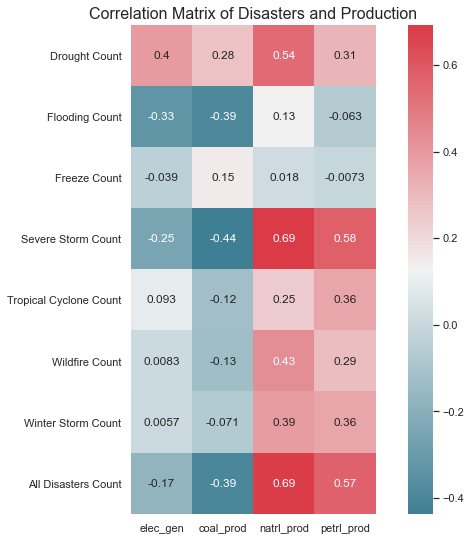

In [7]:
yearly_df = cleaned_df.groupby(['year']).sum().reset_index()
yearly_df = yearly_df.merge(disasters, 
                            left_on = 'year', 
                            right_on = 'Year')
corr = yearly_df.corr()
sns.set_theme(rc={'figure.figsize':(11.7,9)})
plot = sns.heatmap(corr.iloc[6:14, 1:5], 
                    annot=True, 
                    cmap=sns.diverging_palette(220, 
                                               10, 
                                               as_cmap=True),
                    square=True)
plot.set_title(label='Correlation Matrix of Disasters and Production', 
               fontsize=16)
plt.show()

**say sth about the graph above**

Before computing the correlation between CEI values and energy production, we need to clarify the abbreviations used in our CEI dataset. Here, the meaning of `1-6` is the following:  
<font size="2">
>*1. The sum of (a) percentage of the United States with maximum temperatures much below normal and (b) percentage of the United States with maximum temperatures much above normal.  
>2. The sum of (a) percentage of the United States with minimum temperatures much below normal and (b) percentage of the United States with minimum temperatures much above normal.  
>3. The sum of (a) percentage of the United States in severe drought (equivalent ot the lowest tenth percentile) based on the PDSI and (b) percentage of the United States with severe moisture surplus (equivalent to the highest tenth percentile) based on the PDSI.  
>4. Twice the value of the percentage of the United States with a much greater than normal proportion of precipitation derived from extreme (equivalent to the highest tenth percentile) 1-day precipitation events.  
>5. The sum of (a) percentage of the United States with a much greater than normal number of days with precipitation and (b) percentage of the United States with a much greater than normal number of days without precipitation.  
>6. The sum of squares of U.S. landfalling tropical storm and hurricane wind velocities scaled to the mean of the first five indicators.*</font>

Note: the above abbrev. is according to [NCEI](https://www.ncei.noaa.gov/access/monitoring/cei/definition)

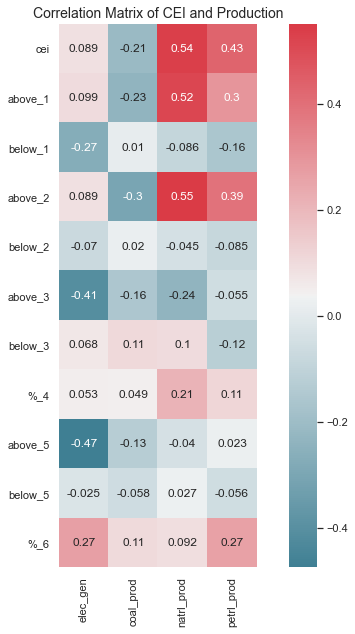

In [8]:
yearly_df = cleaned_df.groupby(['year']).sum().reset_index()
yearly_df = yearly_df.merge(cei, 
                            on = 'year')
corr = yearly_df.corr()
sns.set_theme(rc={'figure.figsize':(11.7, 10)})
plot = sns.heatmap(corr.iloc[5:, 1:5], 
                    annot=True, 
                    cmap=sns.diverging_palette(220, 
                                               10, 
                                               as_cmap=True),
                    square=True)
plot.set_title(label='Correlation Matrix of CEI and Production', 
               fontsize=14)
plt.yticks(rotation=0) 
plt.show()

**say sth**

## Correlation Visualization

In this block, we visualize the correlation between occurence of all disasters with each productions in a yearly manner.  
However, since the data size isn't big and to eliminate wide variances and noises, we decide to use cubic basis spline functions for smoothing, where the cubic B-spline curve $S(t)$ is given by   
$$S(t) = ∑_{i=0}^{n} P_i * N_{i,3}(t),$$  
and the Cox-de Boor recursion formula for the basis functions $N_{i,3}(t)$ is:  

$$N_{i,3}(t) = \frac{t - t_i}{t_{i+3} - t_i} * N_{i,2}(t) + \frac{t_{i+4} - t} {t_{i+4} - t_{i+1}} * N_{i+1,2}(t)
$$


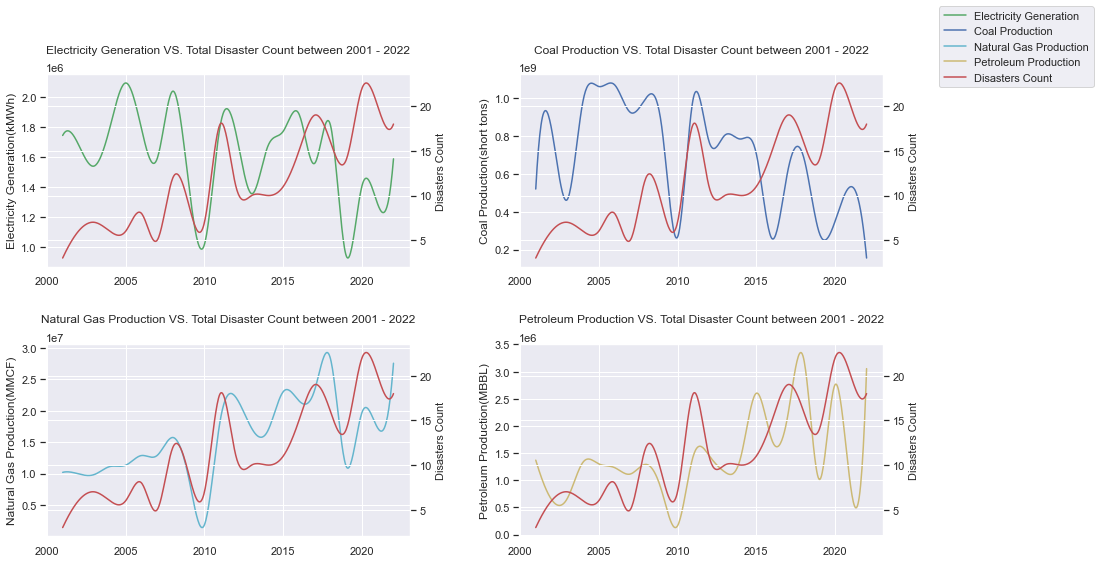

In [30]:
df = yearly_df.merge(disasters, 
                     left_on = 'year', 
                     right_on = 'Year')
fig, axs = plt.subplots(2, 2)
plt.subplots_adjust(hspace = 0.4,
                    wspace = 0.3)
cubic_interpolation_model1 = interp1d(df['year'], 
                                      df['elec_gen'], 
                                      kind = "cubic")
X_1=np.linspace(df['year'].min(), 
                df['year'].max(), 500)
Y_1=cubic_interpolation_model1(X_1)
sns.set(rc={'figure.figsize':(15,8.5)})
axs[0,0] = sns.lineplot(x = X_1, 
                   y = Y_1, 
                   color = 'g', 
                   ax = axs[0,0], 
                   legend = False,
                   label = 'Electricity Generation')
axs[0,0].set_ylabel('Electricity Generation(kMWh)', 
                    size = 12)
ax2 = axs[0,0].twinx()
cubic_interpolation_model = interp1d(df['year'], 
                                     df['All Disasters Count'], 
                                     kind = "cubic")
ax2.set_ylabel('Disasters Count', size = 11)
X_=np.linspace(df['year'].min(), df['year'].max(), 500)
Y_=cubic_interpolation_model(X_)
sns.lineplot(x = X_, 
             y = Y_, 
             ax = ax2, 
             color = 'r', 
             legend = False)
axs[0,0].set_title('Electricity Generation VS. Total Disaster Count between 2001 - 2022', 
                   y=1.08)

cubic_interpolation_model1 = interp1d(df['year'], 
                                      df['coal_prod'], 
                                      kind = "cubic")
X_1=np.linspace(df['year'].min(), df['year'].max(), 500)
Y_1=cubic_interpolation_model1(X_1)
axs[0,1] = sns.lineplot(x = X_1, 
                   y = Y_1, 
                   color = 'b', 
                   ax = axs[0,1], 
                   legend = False,
                   label = 'Coal Production')
axs[0,1].set_ylabel('Coal Production(short tons)', 
                    size = 12)
ax2 = axs[0,1].twinx()
cubic_interpolation_model = interp1d(df['year'], 
                                     df['All Disasters Count'], 
                                     kind = "cubic")
X_=np.linspace(df['year'].min(), df['year'].max(), 500)
Y_=cubic_interpolation_model(X_)
sns.lineplot(x = X_, 
             y = Y_, 
             ax = ax2, 
             color = 'r', 
             legend = False)
ax2.set_ylabel('Disasters Count', size = 11)
axs[0,1].set_title('Coal Production VS. Total Disaster Count between 2001 - 2022', 
                   y=1.08)


cubic_interpolation_model1 = interp1d(df['year'], 
                                      df['petrl_prod'], 
                                      kind = "cubic")
X_1=np.linspace(df['year'].min(), df['year'].max(), 500)
Y_1=cubic_interpolation_model1(X_1)
sns.set(rc={'figure.figsize':(15,8.5)})
axs[1,1] = sns.lineplot(x = X_1, 
                   y = Y_1, 
                   color = 'y', 
                   ax = axs[1,1], 
                   legend = False,
                   label = 'Petroleum Production')
axs[1,1].set_ylabel('Petroleum Production(MBBL)', 
                    size = 12)
ax2 = axs[1,1].twinx()
cubic_interpolation_model = interp1d(df['year'], 
                                     df['All Disasters Count'], 
                                     kind = "cubic")
X_=np.linspace(df['year'].min(), df['year'].max(), 500)
Y_=cubic_interpolation_model(X_)
sns.lineplot(x = X_, 
             y = Y_, 
             ax = ax2, 
             color = 'r', 
             legend = False,
             label = 'Disasters Count')
ax2.set_ylabel('Disasters Count', size = 11)
axs[1,1].set_title('Petroleum Production VS. Total Disaster Count between 2001 - 2022', 
                   y=1.08)

cubic_interpolation_model1 = interp1d(df['year'], 
                                      df['natrl_prod'], 
                                      kind = "cubic")
X_1=np.linspace(df['year'].min(), df['year'].max(), 500)
Y_1=cubic_interpolation_model1(X_1)
axs[1,0] = sns.lineplot(x = X_1, 
                   y = Y_1, 
                   color = 'c', 
                   ax = axs[1,0], 
                   legend = False,
                   label = 'Natural Gas Production')
axs[1,0].set_ylabel('Natural Gas Production(MMCF)', 
                    size = 12)
ax2 = axs[1,0].twinx()
cubic_interpolation_model = interp1d(df['year'], 
                                     df['All Disasters Count'], 
                                     kind = "cubic")
X_=np.linspace(df['year'].min(), df['year'].max(), 500)
Y_=cubic_interpolation_model(X_)
sns.lineplot(x = X_, 
             y = Y_, 
             ax = ax2, 
             color = 'r', 
             legend = False)
ax2.set_ylabel('Disasters Count', size = 11)
axs[1,0].set_title('Natural Gas Production VS. Total Disaster Count between 2001 - 2022', 
                   y=1.08)
axs[1,0].figure.legend(bbox_to_anchor=(1.1, 1))
plt.show()

**The graphs above show...**

We also noticed natural gas production has a relative high positive correlation (*r > 0.5*) with certain CEI factors, hence we decide to visualize natural gas production specifically with CEI, max temperatures and min temperatures. Used cubic basis spline function for interpolation and curve fitting as above.


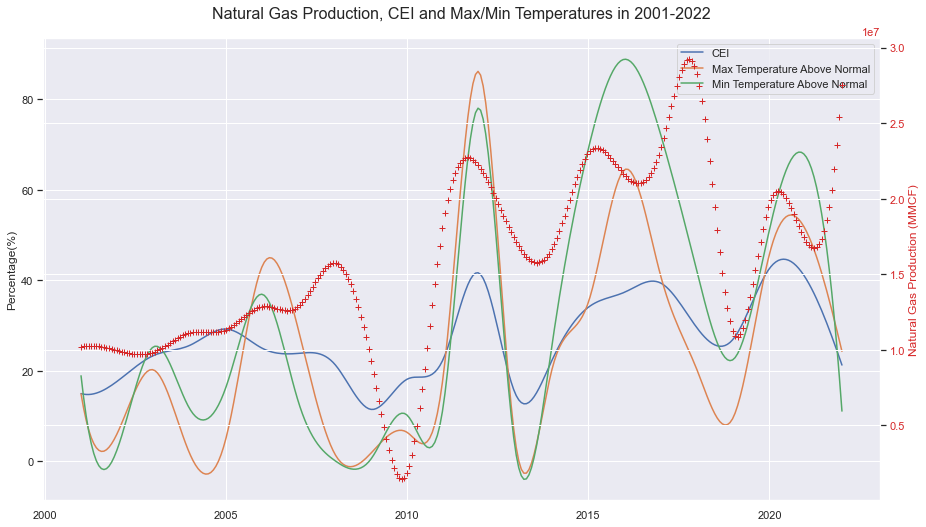

In [10]:
fig, ax1 = plt.subplots()
year_new = np.linspace(df['year'].min(), 
                       df['year'].max(), 
                       300) 
spl = make_interp_spline(df['year'], 
                         df['cei'], 
                         k=3)
cei_new = spl(year_new)
ax1.plot(year_new, cei_new, label = 'CEI')
spl = make_interp_spline(df['year'], 
                         df['above_1'], 
                         k=3)
above1_new = spl(year_new)
ax1.plot(year_new, above1_new, 
         label = 'Max Temperature Above Normal')
spl = make_interp_spline(df['year'], 
                         df['above_2'], 
                         k=3)
above2_new = spl(year_new)
ax1.plot(year_new, above2_new, 
         label = 'Min Temperature Above Normal')
ax1.set_ylabel('Percentage(%)')
ax2 = ax1.twinx()
color = 'tab:red'
spl = make_interp_spline(df['year'], 
                         df['natrl_prod'], 
                         k=3)
natrl_prod_new = spl(year_new)
ax2.plot(year_new, natrl_prod_new, 
         'r+', color = color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel('Natural Gas Production (MMCF)', 
               color = color)
plt.title('Natural Gas Production, CEI and Max/Min Temperatures in 2001-2022', 
          size = 16, 
          y = 1.03)
ax1.legend()
plt.show()

On the other hand, coal production seems to be negatively correlated with certain CEI factors, below is its visualization using cubic basis spline.

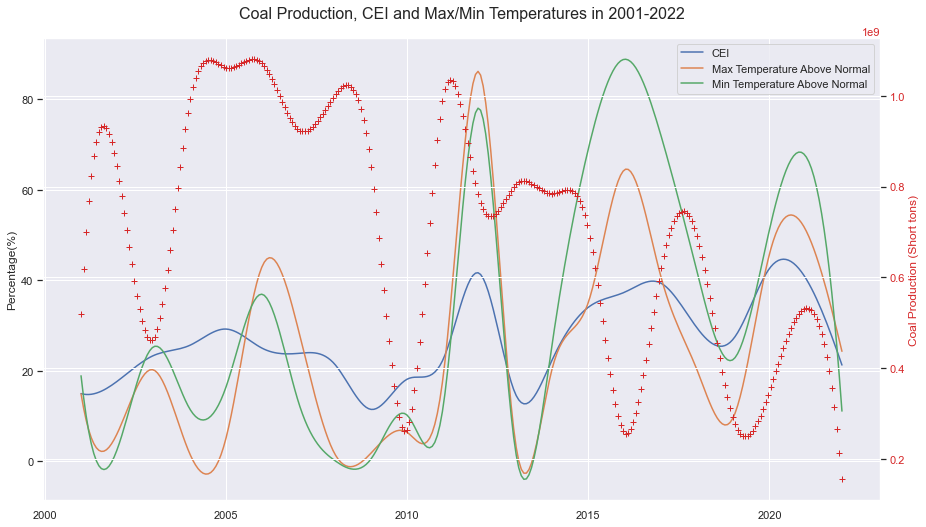

In [11]:
fig, ax1 = plt.subplots()
ax1.plot(year_new, 
         cei_new, 
         label = 'CEI')
ax1.plot(year_new, 
         above1_new, 
         label = 'Max Temperature Above Normal')
ax1.plot(year_new, 
         above2_new, 
         label = 'Min Temperature Above Normal')
ax1.set_ylabel('Percentage(%)')
ax2 = ax1.twinx()
color = 'tab:red'
spl = make_interp_spline(df['year'], 
                         df['coal_prod'], 
                         k=3)
coal_prod_new = spl(year_new)
ax2.plot(year_new, 
         coal_prod_new, 
         'r+', 
         color = color)
ax2.tick_params(axis='y', 
                labelcolor=color)
ax2.set_ylabel('Coal Production (Short tons)', 
               color = color)
ax1.legend()
plt.title('Coal Production, CEI and Max/Min Temperatures in 2001-2022', 
          size = 16, 
          y = 1.03)
plt.show()

# Conclusion

# Discussion